# cifar100 데이터셋 학습 (to do)

CIFAR-100 데이터셋은 총 100개의 label로 이루어진 이미지 분류를 위한 데이터셋이다.

각각의 레이블마다 32×32 크기 이미지인 50,000개의 training 데이터셋, 10,000개의 test 데이터셋이 존재하고, 결과적으로 총 60,000개의 32×32 크기의 이미지로 데이터셋이 구성되어 있다.

## (1) 데이터셋 준비

In [1]:
import tensorflow as tf

from tensorflow.compat.v1 import ConfigProto, Session
from tensorflow.compat.v1.keras.backend import set_session
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction =0.3 #GPU 메모리 사용을 30%로 제한
session = Session(config=config)
set_session(session)

from tensorflow.python.client import device_lib
device_lib.list_local_devices()
import tensorflow.keras.utils as utils
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
(X_train, Y_train), (X_test, Y_test) = datasets.cifar100.load_data()
print(X_train.shape, Y_train.shape)

(50000, 32, 32, 3) (50000, 1)


label :  [19]


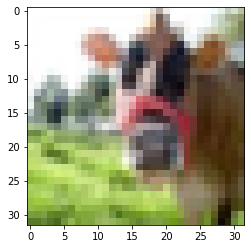

In [3]:
print('label : ',Y_train[0])
plt.imshow(X_train[0])

In [4]:
Y_train = utils.to_categorical(Y_train)
Y_test = utils.to_categorical(Y_test)

print(X_train.shape, Y_train.shape)

(50000, 32, 32, 3) (50000, 100)


## (2) 모델링

In [5]:
from tensorflow.keras.layers import Flatten, BatchNormalization, Dropout, ReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

In [6]:
# datagen = ImageDataGenerator(
#     featurewise_center = False,
#     samplewise_center = False,
#     featurewise_std_normalization = False,
#     samplewise_std_normalization = False,
#     zca_whitening = False,
#     rotation_range = 10, # 회전
#     zoom_range = 0.1, # 확대 축소
#     width_shift_range = 0.1, # 수평 이동
#     height_shift_range = 0.1, # 수직 이동
#     horizontal_flip = False, # 수평 반전
#     vertical_flip = False # 수직 반전
# )

# datagen.fit(X_train)

In [7]:
num_class = 100

model = Sequential()

#Stack 1
#convolution
model.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu", input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(BatchNormalization())
#pooling
model.add(MaxPool2D(pool_size=2, strides=2))
#dropout 
model.add(Dropout(0.2)) 


#Stack 2
#convolution
model.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(BatchNormalization())

#pooling
model.add(MaxPool2D(pool_size=2, strides=2))
#dropout 
model.add(Dropout(0.5))

#Stack 3
#convolution
model.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(BatchNormalization())

#pooling
model.add(MaxPool2D(pool_size=2, strides=2))
#dropout 
model.add(Dropout(0.5))


#flattening
model.add(Flatten())

#full connection
model.add(Dense(units=1000, activation="relu"))
#dropout 
model.add(Dropout(0.5))

#full connection
model.add(Dense(units=1000, activation="relu"))
#dropout 
model.add(Dropout(0.5))

#output layer
model.add(Dense(units=num_class, activation="softmax"))


# In[23]:


model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       5

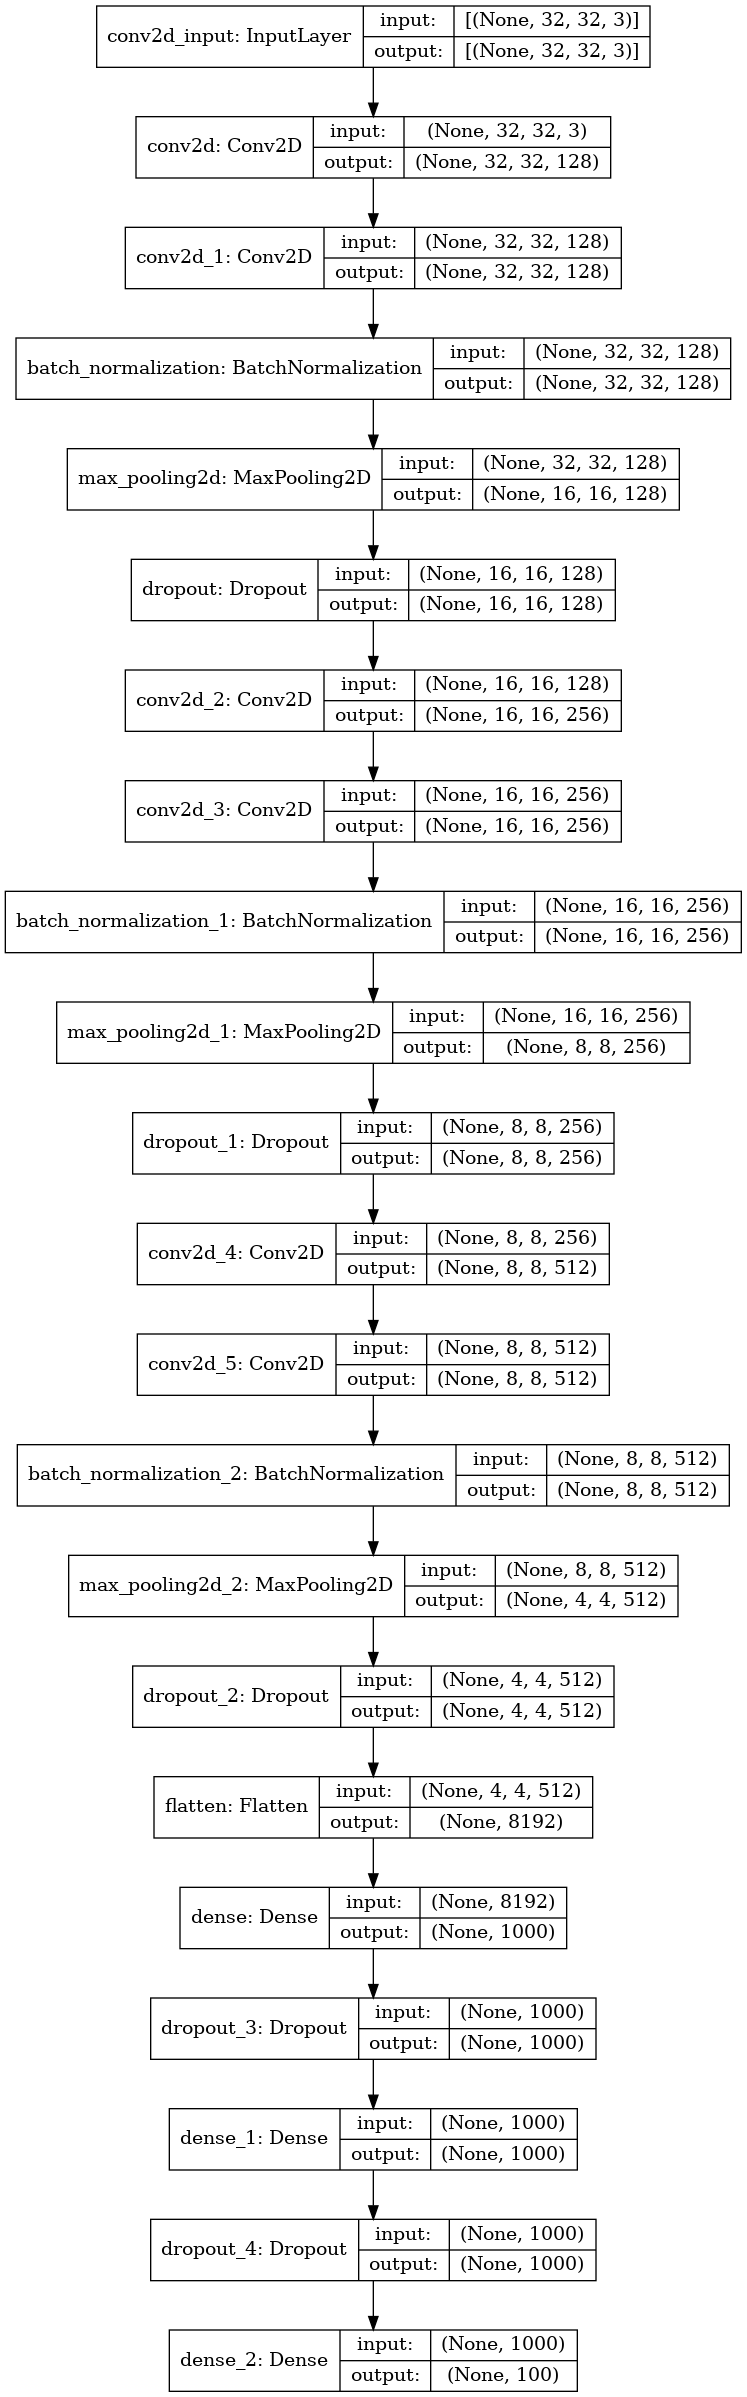

In [8]:
from tensorflow.keras.utils import plot_model
%matplotlib inline

plot_model(model, show_shapes=True)

## (3) 모델의 학습과정 설정

In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [10]:
adam = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, decay=1e-6, epsilon=None, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [11]:
def scheduler(epoch, lr):
    if epoch < 10 :
        return lr
    else :
        return lr*tf.math.exp(-0.1)
learningratedk = LearningRateScheduler(scheduler)

## (4) 모델 학습시키기

In [12]:
earlystopper = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min')

history = model.fit(X_train, Y_train, batch_size=256, epochs=500, validation_split=0.2, callbacks = [earlystopper, learningratedk])

Epoch 1/500
157/157 [==============================] - 115s 485ms/step - loss: 8.1426 - accuracy: 0.0112 - val_loss: 4.5957 - val_accuracy: 0.0168
Epoch 2/500
157/157 [==============================] - 25s 159ms/step - loss: 5.2141 - accuracy: 0.0110 - val_loss: 4.5812 - val_accuracy: 0.0250
Epoch 3/500
157/157 [==============================] - 25s 156ms/step - loss: 4.8142 - accuracy: 0.0112 - val_loss: 4.5639 - val_accuracy: 0.0226
Epoch 4/500
157/157 [==============================] - 25s 159ms/step - loss: 4.7069 - accuracy: 0.0121 - val_loss: 4.5525 - val_accuracy: 0.0235
Epoch 5/500
157/157 [==============================] - 25s 156ms/step - loss: 4.6656 - accuracy: 0.0121 - val_loss: 4.5430 - val_accuracy: 0.0258
Epoch 6/500
157/157 [==============================] - 25s 156ms/step - loss: 4.6402 - accuracy: 0.0132 - val_loss: 4.5352 - val_accuracy: 0.0276
Epoch 7/500
157/157 [==============================] - 24s 156ms/step - loss: 4.6282 - accuracy: 0.0116 - val_loss: 4.5272 

KeyboardInterrupt: 

## (5) 모델 평가하기

In [ ]:
loss_and_accuracy = model.evaluate(X_test, Y_test, batch_size=128)
print('loss : %.4f, accruracy : %.4f'%(loss_and_accuracy[0],loss_and_accuracy[1]))

## (6) 모델 사용하기

In [ ]:
test_data = X_test[-1].reshape(1,32,32,3)
pred_y = model.predict(test_data).argmax()
real_y = Y_test[-1].argmax()
print('predict label : {}, real label : {}'.format(pred_y, real_y))
plt.imshow(X_test[-1].reshape(32,32,3), cmap='gray')